# ANFIS Tool Wear Prediction in CNC Machining (4-input, mixed MFs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = np.array([
    [150, 0.15, 10, 45, 0.12],
    [180, 0.20, 12, 55, 0.18],
    [200, 0.25, 15, 60, 0.25],
    [160, 0.18, 11, 48, 0.15],
    [170, 0.22, 14, 58, 0.20],
    [210, 0.28, 18, 65, 0.30],
    [155, 0.16, 10, 46, 0.13],
    [190, 0.24, 16, 62, 0.23],
    [175, 0.21, 13, 54, 0.18],
    [220, 0.30, 20, 70, 0.35]
])

# Split into inputs and outputs
X = data[:, :4]  # Inputs: Speed, Feed, Vibration, Temp
Y = data[:, 4]   # Output: Tool Wear


# Normalize the inputs (min-max normalization)
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = (X - X_min) / (X_max - X_min)

# Normalize the output (min-max normalization)
Y_min = Y.min()
Y_max = Y.max()
Y_normalized = (Y - Y_min) / (Y_max - Y_min)



In [3]:
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x < c:
        return (c - x) / (c - b)
    else:
        return 0

# Trapezoidal Membership Function
def trapmf(x, a, b, c, d):
    if x <= a or x >= d:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x <= c:
        return 1
    elif c < x < d:
        return (d - x) / (d - c)
    else:
        return 0


In [4]:
mf_params = {
    'speed': [('tri', [140, 150, 180]), ('tri', [180, 210, 230])],
    'feed':  [('tri', [0.10, 0.15, 0.20]), ('tri', [0.20, 0.25, 0.32])],
    'vib':   [('trap', [8, 10, 12, 16]), ('trap', [14, 16, 20, 22])],
    'temp':  [('trap', [40, 45, 50, 55]), ('trap', [55, 60, 65, 75])]
}

# Generate all rules (16 rules for 2 MFs per input)
import itertools
rules = list(itertools.product([0, 1], repeat=4))
num_rules = len(rules)


def get_membership(x, mf_type, params):
    if mf_type == 'tri':
        return trimf(x, *params)
    elif mf_type == 'trap':
        return trapmf(x, *params)
    else:
        return 0


In [5]:
np.random.seed(42)  # for reproducibility
params = np.random.rand(num_rules, 5) * 0.1


def anfis_forward(x):
    weights = []
    outputs = []

    for i, rule in enumerate(rules):
        mu = []
        # Speed
        t, p = mf_params['speed'][rule[0]]
        mu.append(get_membership(x[0], t, p))
        # Feed
        t, p = mf_params['feed'][rule[1]]
        mu.append(get_membership(x[1], t, p))
        # Vibration
        t, p = mf_params['vib'][rule[2]]
        mu.append(get_membership(x[2], t, p))
        # Temp
        t, p = mf_params['temp'][rule[3]]
        mu.append(get_membership(x[3], t, p))

        w = np.prod(mu)  # firing strength
        weights.append(w)
        f = np.dot(params[i, :4], x) + params[i, 4]  # linear output
        outputs.append(f)

    weights = np.array(weights, dtype=float)
    outputs = np.array(outputs, dtype=float)

    weights_sum = np.sum(weights)
    if weights_sum < 1e-6:
        weights += 1e-6  # avoid division by zero
        weights_sum = np.sum(weights)

    y_pred = np.sum(weights * outputs) / weights_sum
    return y_pred


In [6]:
alpha = 0.001  # learning rate
epochs = 500
total_error_history = []

for ep in range(epochs):
    total_error = 0
    for i in range(len(X)):
        x = X_normalized[i]  # Use normalized inputs
        y = Y_normalized[i]  # Use normalized outputs
        y_pred = anfis_forward(x)
        e = y - y_pred
        total_error += e ** 2

        # Update linear parameters for all rules
        for j in range(num_rules):
            params[j, :4] += alpha * e * x
            params[j, 4]  += alpha * e
            # Clip to prevent runaway
            params[j, :4] = np.clip(params[j, :4], -1, 1)
            params[j, 4]  = np.clip(params[j, 4], -1, 1)
    total_error_history.append(total_error)

In [7]:
Y_pred_normalized = np.array([anfis_forward(x) for x in X_normalized])

# Denormalize the predictions
Y_pred_denormalized = Y_pred_normalized * (Y_max - Y_min) + Y_min

# Denormalize the actual values
Y_denormalized = Y * (Y_max - Y_min) + Y_min


In [8]:
print(f"{'Cutting Speed':>13} {'Feed':>6} {'Vibration':>10} {'Temp':>6} | {'Actual':>6} | {'Predicted':>9}")
print("-"*60)

for i in range(len(X)):
    x_input = X[i]
    y_actual = Y_denormalized[i]
    y_pred = Y_pred_denormalized[i]
    print(f"{x_input[0]:13.1f} {x_input[1]:6.2f} {x_input[2]:10.1f} {x_input[3]:6.1f} | {y_actual:6.3f} | {y_pred:9.3f}")


Cutting Speed   Feed  Vibration   Temp | Actual | Predicted
------------------------------------------------------------
        150.0   0.15       10.0   45.0 |  0.148 |     0.132
        180.0   0.20       12.0   55.0 |  0.161 |     0.195
        200.0   0.25       15.0   60.0 |  0.177 |     0.247
        160.0   0.18       11.0   48.0 |  0.154 |     0.158
        170.0   0.22       14.0   58.0 |  0.166 |     0.209
        210.0   0.28       18.0   65.0 |  0.189 |     0.287
        155.0   0.16       10.0   46.0 |  0.150 |     0.140
        190.0   0.24       16.0   62.0 |  0.173 |     0.246
        175.0   0.21       13.0   54.0 |  0.161 |     0.198
        220.0   0.30       20.0   70.0 |  0.200 |     0.318


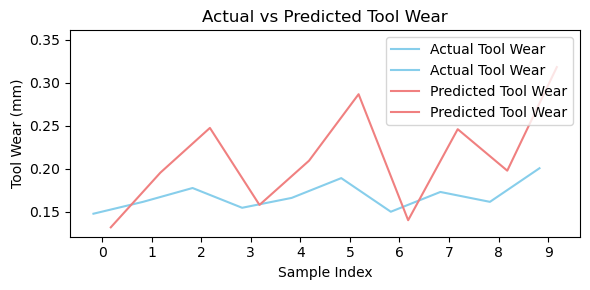

In [9]:
plt.figure(figsize=(6, 3))
indices = np.arange(len(Y))

# Create a bar chart
bar_width = 0.35
plt.plot(indices - bar_width/2, Y_denormalized, bar_width, label='Actual Tool Wear', color='skyblue')
plt.plot(indices + bar_width/2, Y_pred_denormalized, bar_width, label='Predicted Tool Wear', color='lightcoral')

# Adding labels, title, and legend
plt.xlabel('Sample Index')
plt.ylabel('Tool Wear (mm)')
plt.title('Actual vs Predicted Tool Wear')
plt.xticks(indices)
plt.legend()

# Display the bar chart
plt.tight_layout()
plt.show()


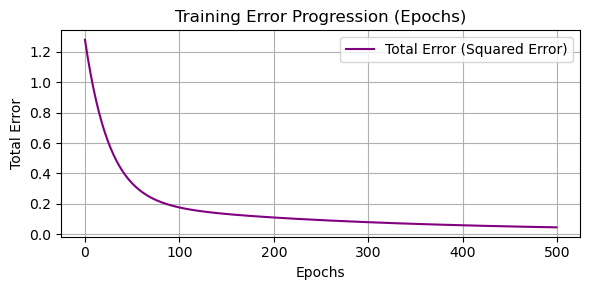

RMSE = 0.0619
R²   = 0.9807


In [10]:
# Visualization: Line chart for Total Error Progression over Epochs
plt.figure(figsize=(6, 3))
plt.plot(total_error_history, color='purple', label='Total Error (Squared Error)')
plt.xlabel('Epochs')
plt.ylabel('Total Error')
plt.title('Training Error Progression (Epochs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Calculate RMSE and R²
rmse = np.sqrt(np.mean((Y_denormalized - Y_pred_denormalized) ** 2))
r = np.corrcoef(Y_denormalized, Y_pred_denormalized)[0, 1]
r2 = r ** 2

print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")